In [3]:
from util import api_hook as ap
import nest_asyncio
nest_asyncio.apply()  # Allo
api_key="362de69bbf9e42f7b9e41b6563dee0a2"

In [4]:
fetch =ap(output_path="fetched_data.json")
fetch.run(f"https://newsapi.org/v2/everything?q=apple&from=2025-01-23&to=2025-01-23&sortBy=popularity&apiKey={api_key}")

Data saved to fetched_data.json


# WORD

In [1]:
import json
import pandas as pd
from model import SkipGramModel
from util import createPairs
import nltk
import numpy as np
from tqdm import tqdm
import pickle
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
with open("fetched_data.json", "r") as file:
    json_data = json.load(file)
df = pd.json_normalize(json_data['articles'])
df.head(1)

,author,title,description,url,urlToImage,publishedAt,content,source.id,source.name
0,Joe Tilleli,"Forget Apple, HP Professional Laptop With Micr...",Save $900 on the HP 255-G10 business laptop co...,https://gizmodo.com/forget-apple-hp-profession...,https://gizmodo.com/app/uploads/2025/01/HPBusi...,2025-01-23T14:35:41Z,Are you the owner of a small business? Do you ...,None,Gizmodo.com


In [2]:
df.drop(labels=['urlToImage','publishedAt','source.id','source.name','url','author'],axis=1,inplace=True)

In [3]:
pairs =  createPairs(df,drop=True)
vocab,word_pairs = pairs.get_vocab_and_pairs(column='content')

In [4]:
word_pairs,vocab

([('owner', 'small'),
  ('small', 'owner'),
  ('small', 'business'),
  ('business', 'small'),
  ('business', 'find'),
  ('find', 'business'),
  ('find', 'bringing'),
  ('bringing', 'find'),
  ('bringing', 'work'),
  ('work', 'bringing'),
  ('work', 'home'),
  ('home', 'work'),
  ('home', 'occasion'),
  ('occasion', 'home'),
  ('occasion', 'make'),
  ('make', 'occasion'),
  ('make', 'sure'),
  ('sure', 'make'),
  ('sure', 'right'),
  ('right', 'sure'),
  ('right', 'laptop'),
  ('laptop', 'right'),
  ('laptop', 'job'),
  ('job', 'laptop'),
  ('job', 'amazon'),
  ('amazon', 'job'),
  ('amazon', 'limited'),
  ('limited', 'amazon'),
  ('limited', 'time'),
  ('time', 'limited'),
  ('time', 'chars'),
  ('chars', 'time'),
  ('countries', 'world'),
  ('world', 'countries'),
  ('world', 'anxiously'),
  ('anxiously', 'world'),
  ('anxiously', 'awaiting'),
  ('awaiting', 'anxiously'),
  ('awaiting', 'return'),
  ('return', 'awaiting'),
  ('return', 'donald'),
  ('donald', 'return'),
  ('donald', '

In [5]:
model =SkipGramModel(vocab_size=len(vocab),embedding_dim=20)

In [6]:

def plot_embeddings_tsne(embeddings, words_to_plot=None):
    if words_to_plot:
        selected_embeddings = {word: embeddings[word] for word in words_to_plot if word in embeddings}
    else:
        selected_embeddings = embeddings
    words = list(selected_embeddings.keys())
    vectors = np.array([selected_embeddings[word] for word in words])
    tsne = TSNE(n_components=2, random_state=42)
    reduced_vectors = tsne.fit_transform(vectors)
    plt.figure(figsize=(10, 10))
    plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], edgecolors='k', c='r')
    for i, word in enumerate(words):
        plt.annotate(word, (reduced_vectors[i, 0], reduced_vectors[i, 1]))
    plt.title('Word Embeddings Visualized with t-SNE')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.grid(True)
    plt.show()
def compute_cosine_similarity(embeddings):
    words = list(embeddings.keys())
    vectors = np.array([embeddings[word] for word in words])
    similarity_matrix = cosine_similarity(vectors)
    similarity_df = pd.DataFrame(similarity_matrix, index=words, columns=words)
    return similarity_df
def get_top_n_similar(similarity_df, word, top_n=5):
    if word not in similarity_df.columns:
        raise ValueError(f"Word '{word}' not found in similarity matrix.")
    sorted_similarities = similarity_df[word].sort_values(ascending=False)
    top_similar = sorted_similarities.drop(labels=[word]).head(top_n)
    return list(zip(top_similar.index, top_similar.values))
def extract_embeddings(model, word2idx):
    embeddings = {}
    for word, idx in word2idx.items():
        embeddings[word] = model.W1[idx]
    return embeddings




In [7]:
def train_example(vocab, training_pairs, epochs, learning_rate=0.01):
    word2idx = {word: idx for idx, word in enumerate(vocab)}
    model = SkipGramModel(vocab_size=len(vocab), embedding_dim=20)
    loss_history = []
    if not isinstance(training_pairs, list):
        training_pairs = list(training_pairs)
    total_pairs = len(training_pairs)  # Total number of training pairs
    for epoch in range(1, epochs + 1):
        total_loss = 0  # Reset total loss for the current epoch
        with tqdm(total=total_pairs, desc=f"Epoch {epoch}/{epochs}", unit="pair") as pbar:
            for i, (target_word, context_word) in enumerate(training_pairs, start=1):
                target_vector = np.zeros(len(vocab))
                target_vector[word2idx[target_word]] = 1
                context_vector = np.zeros(len(vocab))
                context_vector[word2idx[context_word]] = 1
                hidden, output = model.forward(target_vector)
                epsilon = 1e-10 
                loss = -np.log(output[word2idx[context_word]] + epsilon)
                model.backward(target_vector, context_vector, learning_rate=learning_rate)
                total_loss += loss
                if i % 20 == 0:
                    pbar.update(20)  
                    pbar.set_postfix(loss=loss)  
            remainder = total_pairs % 20
            if remainder != 0:
                pbar.update(remainder)
                pbar.set_postfix(loss=loss)
        average_loss = total_loss / total_pairs
        loss_history.append(average_loss)
        print(f"Epoch {epoch}/{epochs}, Average Loss: {average_loss:.6f}")
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), loss_history, marker='o')
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.grid(True)
    plt.show()
    
    return model, word2idx

Epoch 1/100: 100%|██████████| 3240/3240 [00:00<00:00, 6131.05pair/s, loss=6.93]


Epoch 1/100, Average Loss: 6.934378


Epoch 2/100: 100%|██████████| 3240/3240 [00:00<00:00, 5962.52pair/s, loss=6.93]


Epoch 2/100, Average Loss: 6.934116


Epoch 3/100: 100%|██████████| 3240/3240 [00:00<00:00, 6006.36pair/s, loss=6.93]


Epoch 3/100, Average Loss: 6.933055


Epoch 4/100: 100%|██████████| 3240/3240 [00:00<00:00, 6042.88pair/s, loss=6.92]


Epoch 4/100, Average Loss: 6.925997


Epoch 5/100: 100%|██████████| 3240/3240 [00:00<00:00, 5831.28pair/s, loss=6.89]


Epoch 5/100, Average Loss: 6.876789


Epoch 6/100: 100%|██████████| 3240/3240 [00:00<00:00, 6056.31pair/s, loss=6.74] 


Epoch 6/100, Average Loss: 6.739032


Epoch 7/100: 100%|██████████| 3240/3240 [00:00<00:00, 6005.13pair/s, loss=6.3]  


Epoch 7/100, Average Loss: 6.573149


Epoch 8/100: 100%|██████████| 3240/3240 [00:00<00:00, 5893.27pair/s, loss=5.82] 


Epoch 8/100, Average Loss: 6.409519


Epoch 9/100: 100%|██████████| 3240/3240 [00:00<00:00, 5944.59pair/s, loss=5.68] 


Epoch 9/100, Average Loss: 6.265743


Epoch 10/100: 100%|██████████| 3240/3240 [00:00<00:00, 5990.96pair/s, loss=5.75] 


Epoch 10/100, Average Loss: 6.105399


Epoch 11/100: 100%|██████████| 3240/3240 [00:00<00:00, 6060.71pair/s, loss=5.79] 


Epoch 11/100, Average Loss: 5.912622


Epoch 12/100: 100%|██████████| 3240/3240 [00:00<00:00, 5906.89pair/s, loss=5.78] 


Epoch 12/100, Average Loss: 5.694197


Epoch 13/100: 100%|██████████| 3240/3240 [00:00<00:00, 6034.35pair/s, loss=5.78] 


Epoch 13/100, Average Loss: 5.450634


Epoch 14/100: 100%|██████████| 3240/3240 [00:00<00:00, 6019.63pair/s, loss=5.77] 


Epoch 14/100, Average Loss: 5.191312


Epoch 15/100: 100%|██████████| 3240/3240 [00:00<00:00, 5879.36pair/s, loss=5.7]  


Epoch 15/100, Average Loss: 4.929608


Epoch 16/100: 100%|██████████| 3240/3240 [00:00<00:00, 6040.21pair/s, loss=5.59] 


Epoch 16/100, Average Loss: 4.680337


Epoch 17/100: 100%|██████████| 3240/3240 [00:00<00:00, 6034.44pair/s, loss=5.5]  


Epoch 17/100, Average Loss: 4.443758


Epoch 18/100: 100%|██████████| 3240/3240 [00:00<00:00, 5728.88pair/s, loss=5.44] 


Epoch 18/100, Average Loss: 4.218850


Epoch 19/100: 100%|██████████| 3240/3240 [00:00<00:00, 6030.29pair/s, loss=5.4]  


Epoch 19/100, Average Loss: 4.005389


Epoch 20/100: 100%|██████████| 3240/3240 [00:00<00:00, 5821.46pair/s, loss=5.37] 


Epoch 20/100, Average Loss: 3.804233


Epoch 21/100: 100%|██████████| 3240/3240 [00:00<00:00, 5953.95pair/s, loss=5.36] 


Epoch 21/100, Average Loss: 3.617660


Epoch 22/100: 100%|██████████| 3240/3240 [00:00<00:00, 6034.60pair/s, loss=5.34] 


Epoch 22/100, Average Loss: 3.446370


Epoch 23/100: 100%|██████████| 3240/3240 [00:00<00:00, 6006.36pair/s, loss=5.34] 


Epoch 23/100, Average Loss: 3.290137


Epoch 24/100: 100%|██████████| 3240/3240 [00:00<00:00, 5827.95pair/s, loss=5.33] 


Epoch 24/100, Average Loss: 3.148527


Epoch 25/100: 100%|██████████| 3240/3240 [00:00<00:00, 5841.03pair/s, loss=5.32] 


Epoch 25/100, Average Loss: 3.020446


Epoch 26/100: 100%|██████████| 3240/3240 [00:00<00:00, 5854.83pair/s, loss=5.32] 


Epoch 26/100, Average Loss: 2.904347


Epoch 27/100: 100%|██████████| 3240/3240 [00:00<00:00, 5788.84pair/s, loss=5.33] 


Epoch 27/100, Average Loss: 2.798665


Epoch 28/100: 100%|██████████| 3240/3240 [00:00<00:00, 5913.35pair/s, loss=5.33] 


Epoch 28/100, Average Loss: 2.702352


Epoch 29/100: 100%|██████████| 3240/3240 [00:00<00:00, 5902.95pair/s, loss=5.34] 


Epoch 29/100, Average Loss: 2.615581


Epoch 30/100: 100%|██████████| 3240/3240 [00:00<00:00, 5798.28pair/s, loss=5.35] 


Epoch 30/100, Average Loss: 2.539755


Epoch 31/100: 100%|██████████| 3240/3240 [00:00<00:00, 6002.04pair/s, loss=5.37] 


Epoch 31/100, Average Loss: 2.476535


Epoch 32/100: 100%|██████████| 3240/3240 [00:00<00:00, 5927.51pair/s, loss=5.39] 


Epoch 32/100, Average Loss: 2.426831


Epoch 33/100: 100%|██████████| 3240/3240 [00:00<00:00, 5788.67pair/s, loss=5.41] 


Epoch 33/100, Average Loss: 2.390350


Epoch 34/100: 100%|██████████| 3240/3240 [00:00<00:00, 5761.25pair/s, loss=5.45] 


Epoch 34/100, Average Loss: 2.365374


Epoch 35/100: 100%|██████████| 3240/3240 [00:00<00:00, 5669.50pair/s, loss=5.48] 


Epoch 35/100, Average Loss: 2.349331


Epoch 36/100: 100%|██████████| 3240/3240 [00:00<00:00, 5918.69pair/s, loss=5.51] 


Epoch 36/100, Average Loss: 2.339868


Epoch 37/100: 100%|██████████| 3240/3240 [00:00<00:00, 5914.75pair/s, loss=5.54] 


Epoch 37/100, Average Loss: 2.335231


Epoch 38/100: 100%|██████████| 3240/3240 [00:00<00:00, 5824.72pair/s, loss=5.55] 


Epoch 38/100, Average Loss: 2.334069


Epoch 39/100: 100%|██████████| 3240/3240 [00:00<00:00, 5935.81pair/s, loss=5.55] 


Epoch 39/100, Average Loss: 2.335405


Epoch 40/100: 100%|██████████| 3240/3240 [00:00<00:00, 5982.77pair/s, loss=5.54] 


Epoch 40/100, Average Loss: 2.338560


Epoch 41/100: 100%|██████████| 3240/3240 [00:00<00:00, 5707.25pair/s, loss=5.52] 


Epoch 41/100, Average Loss: 2.342986


Epoch 42/100: 100%|██████████| 3240/3240 [00:00<00:00, 6117.14pair/s, loss=5.51] 


Epoch 42/100, Average Loss: 2.348306


Epoch 43/100: 100%|██████████| 3240/3240 [00:00<00:00, 6129.52pair/s, loss=5.49] 


Epoch 43/100, Average Loss: 2.354187


Epoch 44/100: 100%|██████████| 3240/3240 [00:00<00:00, 5846.37pair/s, loss=5.47] 


Epoch 44/100, Average Loss: 2.360510


Epoch 45/100: 100%|██████████| 3240/3240 [00:00<00:00, 5735.54pair/s, loss=5.45] 


Epoch 45/100, Average Loss: 2.367108


Epoch 46/100: 100%|██████████| 3240/3240 [00:00<00:00, 5702.05pair/s, loss=5.43] 


Epoch 46/100, Average Loss: 2.373864


Epoch 47/100: 100%|██████████| 3240/3240 [00:00<00:00, 5865.79pair/s, loss=5.4]  


Epoch 47/100, Average Loss: 2.380705


Epoch 48/100: 100%|██████████| 3240/3240 [00:00<00:00, 5837.62pair/s, loss=5.38] 


Epoch 48/100, Average Loss: 2.387550


Epoch 49/100: 100%|██████████| 3240/3240 [00:00<00:00, 5535.58pair/s, loss=5.37] 


Epoch 49/100, Average Loss: 2.394355


Epoch 50/100: 100%|██████████| 3240/3240 [00:00<00:00, 5797.76pair/s, loss=5.35] 


Epoch 50/100, Average Loss: 2.401110


Epoch 51/100: 100%|██████████| 3240/3240 [00:00<00:00, 5887.16pair/s, loss=5.33] 


Epoch 51/100, Average Loss: 2.407793


Epoch 52/100: 100%|██████████| 3240/3240 [00:00<00:00, 5540.48pair/s, loss=5.31] 


Epoch 52/100, Average Loss: 2.414414


Epoch 53/100: 100%|██████████| 3240/3240 [00:00<00:00, 5436.92pair/s, loss=5.29] 


Epoch 53/100, Average Loss: 2.420945


Epoch 54/100: 100%|██████████| 3240/3240 [00:00<00:00, 5589.73pair/s, loss=5.28] 


Epoch 54/100, Average Loss: 2.427393


Epoch 55/100: 100%|██████████| 3240/3240 [00:00<00:00, 5701.75pair/s, loss=5.26] 


Epoch 55/100, Average Loss: 2.433770


Epoch 56/100: 100%|██████████| 3240/3240 [00:00<00:00, 5646.86pair/s, loss=5.24] 


Epoch 56/100, Average Loss: 2.440049


Epoch 57/100: 100%|██████████| 3240/3240 [00:00<00:00, 5491.45pair/s, loss=5.22] 


Epoch 57/100, Average Loss: 2.446239


Epoch 58/100: 100%|██████████| 3240/3240 [00:00<00:00, 4675.28pair/s, loss=5.2]  


Epoch 58/100, Average Loss: 2.452335


Epoch 59/100: 100%|██████████| 3240/3240 [00:00<00:00, 4389.15pair/s, loss=5.18] 


Epoch 59/100, Average Loss: 2.458324


Epoch 60/100: 100%|██████████| 3240/3240 [00:00<00:00, 4891.21pair/s, loss=5.17]


Epoch 60/100, Average Loss: 2.464187


Epoch 61/100: 100%|██████████| 3240/3240 [00:00<00:00, 4528.39pair/s, loss=5.15] 


Epoch 61/100, Average Loss: 2.469946


Epoch 62/100: 100%|██████████| 3240/3240 [00:00<00:00, 4830.44pair/s, loss=5.13] 


Epoch 62/100, Average Loss: 2.475604


Epoch 63/100: 100%|██████████| 3240/3240 [00:00<00:00, 4988.59pair/s, loss=5.11] 


Epoch 63/100, Average Loss: 2.481171


Epoch 64/100: 100%|██████████| 3240/3240 [00:00<00:00, 5386.49pair/s, loss=5.1]  


Epoch 64/100, Average Loss: 2.486652


Epoch 65/100: 100%|██████████| 3240/3240 [00:00<00:00, 5398.93pair/s, loss=5.09] 


Epoch 65/100, Average Loss: 2.492056


Epoch 66/100: 100%|██████████| 3240/3240 [00:00<00:00, 5429.51pair/s, loss=5.08] 


Epoch 66/100, Average Loss: 2.497368


Epoch 67/100: 100%|██████████| 3240/3240 [00:00<00:00, 4681.10pair/s, loss=5.07] 


Epoch 67/100, Average Loss: 2.502593


Epoch 68/100: 100%|██████████| 3240/3240 [00:00<00:00, 4819.14pair/s, loss=5.06] 


Epoch 68/100, Average Loss: 2.507724


Epoch 69/100: 100%|██████████| 3240/3240 [00:00<00:00, 5028.14pair/s, loss=5.05] 


Epoch 69/100, Average Loss: 2.512757


Epoch 70/100: 100%|██████████| 3240/3240 [00:00<00:00, 4961.56pair/s, loss=5.05] 


Epoch 70/100, Average Loss: 2.517691


Epoch 71/100: 100%|██████████| 3240/3240 [00:00<00:00, 5123.84pair/s, loss=5.04] 


Epoch 71/100, Average Loss: 2.522527


Epoch 72/100: 100%|██████████| 3240/3240 [00:00<00:00, 4845.33pair/s, loss=5.04] 


Epoch 72/100, Average Loss: 2.527218


Epoch 73/100: 100%|██████████| 3240/3240 [00:00<00:00, 4985.44pair/s, loss=5.04] 


Epoch 73/100, Average Loss: 2.531777


Epoch 74/100: 100%|██████████| 3240/3240 [00:00<00:00, 5187.85pair/s, loss=5.04] 


Epoch 74/100, Average Loss: 2.536221


Epoch 75/100: 100%|██████████| 3240/3240 [00:00<00:00, 5001.30pair/s, loss=5.04] 


Epoch 75/100, Average Loss: 2.540563


Epoch 76/100: 100%|██████████| 3240/3240 [00:00<00:00, 5330.93pair/s, loss=5.04] 


Epoch 76/100, Average Loss: 2.544800


Epoch 77/100: 100%|██████████| 3240/3240 [00:00<00:00, 4549.41pair/s, loss=5.04] 


Epoch 77/100, Average Loss: 2.548935


Epoch 78/100: 100%|██████████| 3240/3240 [00:00<00:00, 4795.02pair/s, loss=5.04] 


Epoch 78/100, Average Loss: 2.552976


Epoch 79/100: 100%|██████████| 3240/3240 [00:00<00:00, 5091.04pair/s, loss=5.05] 


Epoch 79/100, Average Loss: 2.556921


Epoch 80/100: 100%|██████████| 3240/3240 [00:00<00:00, 5172.74pair/s, loss=5.05] 


Epoch 80/100, Average Loss: 2.560763


Epoch 81/100: 100%|██████████| 3240/3240 [00:00<00:00, 5055.52pair/s, loss=5.05] 


Epoch 81/100, Average Loss: 2.564493


Epoch 82/100: 100%|██████████| 3240/3240 [00:00<00:00, 5163.87pair/s, loss=5.06] 


Epoch 82/100, Average Loss: 2.568127


Epoch 83/100: 100%|██████████| 3240/3240 [00:00<00:00, 4790.33pair/s, loss=5.06] 


Epoch 83/100, Average Loss: 2.571666


Epoch 84/100: 100%|██████████| 3240/3240 [00:00<00:00, 4679.91pair/s, loss=5.06] 


Epoch 84/100, Average Loss: 2.575121


Epoch 85/100: 100%|██████████| 3240/3240 [00:00<00:00, 4864.48pair/s, loss=5.07] 


Epoch 85/100, Average Loss: 2.578501


Epoch 86/100: 100%|██████████| 3240/3240 [00:00<00:00, 4896.69pair/s, loss=5.07] 


Epoch 86/100, Average Loss: 2.581809


Epoch 87/100: 100%|██████████| 3240/3240 [00:00<00:00, 5208.76pair/s, loss=5.08] 


Epoch 87/100, Average Loss: 2.585068


Epoch 88/100: 100%|██████████| 3240/3240 [00:00<00:00, 5009.78pair/s, loss=5.09] 


Epoch 88/100, Average Loss: 2.588271


Epoch 89/100: 100%|██████████| 3240/3240 [00:00<00:00, 5164.50pair/s, loss=5.09] 


Epoch 89/100, Average Loss: 2.591405


Epoch 90/100: 100%|██████████| 3240/3240 [00:00<00:00, 5040.61pair/s, loss=5.1]  


Epoch 90/100, Average Loss: 2.594457


Epoch 91/100: 100%|██████████| 3240/3240 [00:00<00:00, 5012.92pair/s, loss=5.1]  


Epoch 91/100, Average Loss: 2.597417


Epoch 92/100: 100%|██████████| 3240/3240 [00:00<00:00, 4972.79pair/s, loss=5.11] 


Epoch 92/100, Average Loss: 2.600271


Epoch 93/100: 100%|██████████| 3240/3240 [00:00<00:00, 5046.59pair/s, loss=5.12] 


Epoch 93/100, Average Loss: 2.603046


Epoch 94/100: 100%|██████████| 3240/3240 [00:00<00:00, 5016.65pair/s, loss=5.12] 


Epoch 94/100, Average Loss: 2.605741


Epoch 95/100: 100%|██████████| 3240/3240 [00:00<00:00, 5055.24pair/s, loss=5.13] 


Epoch 95/100, Average Loss: 2.608350


Epoch 96/100: 100%|██████████| 3240/3240 [00:00<00:00, 4515.70pair/s, loss=5.14] 


Epoch 96/100, Average Loss: 2.610879


Epoch 97/100: 100%|██████████| 3240/3240 [00:00<00:00, 4764.80pair/s, loss=5.15] 


Epoch 97/100, Average Loss: 2.613328


Epoch 98/100: 100%|██████████| 3240/3240 [00:00<00:00, 5022.00pair/s, loss=5.16] 


Epoch 98/100, Average Loss: 2.615704


Epoch 99/100: 100%|██████████| 3240/3240 [00:00<00:00, 4005.21pair/s, loss=5.17] 


Epoch 99/100, Average Loss: 2.618006


Epoch 100/100: 100%|██████████| 3240/3240 [00:00<00:00, 4503.74pair/s, loss=5.17] 


Epoch 100/100, Average Loss: 2.620221


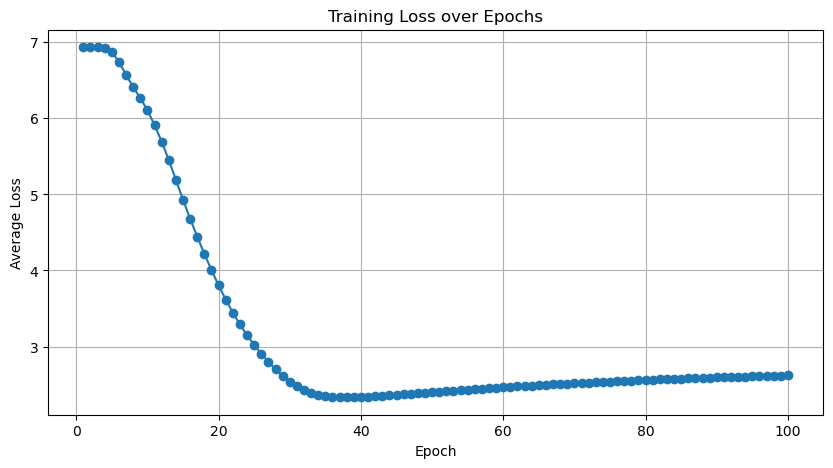

In [8]:
model,word2idx=train_example(vocab=vocab,training_pairs=word_pairs,epochs=100,learning_rate=0.1)

In [ ]:

embeddings = extract_embeddings(model, word2idx)
with open('word_embeddings.pkl', 'wb') as f:
    pickle.dump(embeddings, f)

In [16]:
import pickle
with open('skipgram_model.pkl', 'wb') as f:
    pickle.dump(model, f)


In [19]:
similarity_df = compute_cosine_similarity(embeddings)
word = 'business'
top_similar = get_top_n_similar(similarity_df, word, top_n=5)
print(f"Top 5 words similar to '{word}':")
for similar_word, score in top_similar:
    print(f"{similar_word}: {score:.4f}")

Top 5 words similar to 'business':
pressed: 0.7275
china: 0.6951
preinstall: 0.6241
deluxe: 0.6135
owner: 0.5982


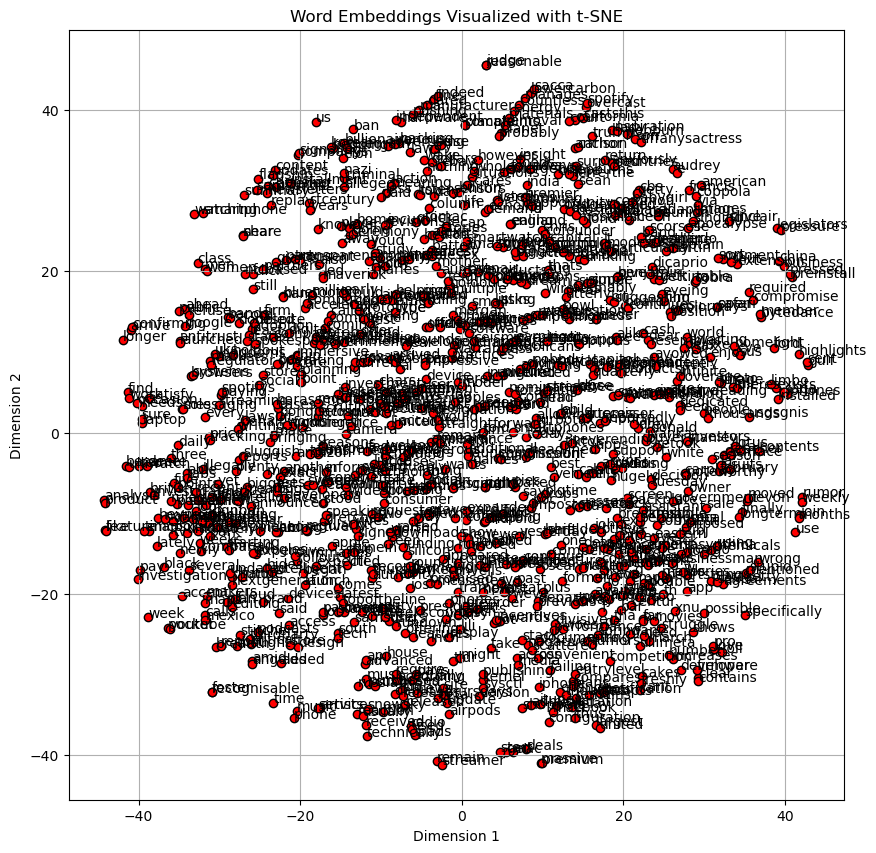

In [12]:
plot_embeddings_tsne(embeddings)